In [60]:
import json
import numpy as np
import os

In [61]:
# all_passes = []

# for filename in os.listdir("data"):
#     if filename.endswith(".json"): 
#         with open("data/" + filename) as json_file:
#             print("Loading data from {}".format(filename))
#             data = json.load(json_file)
            
#             print("Getting trajectories...")
#             trajectories = getTrajectories(data['events'])
            
#             print("Filtering passes...")
#             passes = getPasses(trajectories)

#             all_passes = all_passes + passes
#             saveData(all_passes)
#             print("Data updated")
#     else:
#         continue

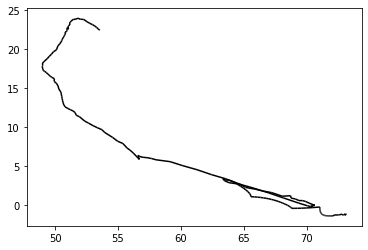

In [81]:
all_passes = []

with open("data/" + "0021500232.json") as json_file:
    data = json.load(json_file)
    trajectories = getTrajectories(data['events'])
    passes = getPasses(trajectories)
            
    all_passes = all_passes + passes
    saveData(all_passes)

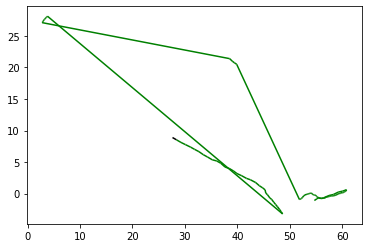

In [94]:
plotTraj(trajectories, k=100)

In [80]:
def getTrajectories(events):
    # Clean the data -- some events are duplicates but have differing lengths; keep the longer event
    start_times = dict()
    
    for i, event in enumerate(events):
        if len(event['moments']) == 0:
            continue

        start_time = event['moments'][0][1]
        if start_time not in start_times.keys():
            start_times[start_time] = (i, len(event['moments']))

        else:
            if len(event['moments']) > start_times[start_time][1]:
                start_times[start_time] = (i, len(event['moments']))
                
    # Just look at ball location for now
    game_locs = []

    for start_time, (index, length) in start_times.items():
        event = events[index]
        event_locs = []

        for moment in event['moments']:
            ball_x = moment[5][0][2]
            ball_y = moment[5][0][3]
            event_locs.append([ball_x, ball_y])

        if len(event_locs) > 50:
            game_locs.append(event_locs)
            
    # Make all trajectories line up defense -> offense half
    for traj in game_locs:
        init_x = traj[0][0]
        final_x = traj[-1][0]
        
        init_in_left = init_x < 46
        final_in_left = final_x < 46
      
        if init_in_left != final_in_left: # crosses the half-court line
            # Make trajectory move from left to right
            if init_x > final_x:
                traj.reverse()
        else: # assume offensive play
            if final_in_left: # flip over to the offensive side
                for point in traj:
                    dist_from_half = 46 - point[0]
                    point[0] += (2*dist_from_half)
                    
    return game_locs

In [88]:
def plotTraj(game_locs, k=3):

    import matplotlib.pyplot as plt 
    from matplotlib import collections
    import random

    line_set = []
    color_set = []
    for event_locs in game_locs[k:k+1]:
        event_color = random.choice(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
        for i in range(len(event_locs)-1):
            segment = [event_locs[i], event_locs[i+1]]
            line_set.append(segment)
            if i==0:
                color_set.append('black')
            else:
                color_set.append(event_color)

    collection = collections.LineCollection(line_set, color=color_set)
    fig,axes=plt.subplots(1,1)
    axes.add_collection(collection)
    axes.autoscale()
    plt.show()

In [53]:
def getPasses(game_locs, overall_angle_threshold=0.05, ind_angle_threshold = 0.25, min_dist = 7.0):
    # Filter out straight passes
    passes = []

    for event_locs in game_locs[:]:
        game_passes = []

        start_index = -1
        tracking_pass = False
        pass_dist = 0
        init_pass_angle = 0
        last_angle = 0

        event_locs = np.array(event_locs)
        deltas = np.diff(event_locs, axis=0)
        angles = np.arctan2(deltas[:, 1], deltas[:, 0])

        for i, loc in enumerate(np.array(event_locs)):
            if i == len(event_locs)-3:
                break

            if not tracking_pass: # Check if pass distance passes threshold

    #             print("Pass dist -- {}".format(pass_dist))

                if pass_dist > min_dist: # Add to passes
                    start_loc = event_locs[start_index]
                    end_loc = event_locs[i-1]
                    passes.append([start_loc, end_loc])
                    game_passes.append([start_loc, end_loc])

    #                 print("Adding pass")

                # Start new test for pass
                tracking_pass = True
                start_index = i

                pass_dist = np.linalg.norm(deltas[i], ord=2)
                init_pass_angle = np.mean([
                    np.arctan2(deltas[i][1], deltas[i][0]),
                    np.arctan2(deltas[i+1][1], deltas[i+1][0]),
                    np.arctan2(deltas[i+2][1], deltas[i+2][0])]
                )
                last_angle = init_pass_angle

    #             print("Starting new pass check from {}".format(loc))
    #             print("Starting pass angle {}\n".format(init_pass_angle))

            else: # See if still a valid pass
                start_loc = event_locs[start_index]
                overall_delta = loc - start_loc

                overall_angle = np.arctan2(overall_delta[1], overall_delta[0])
                ind_angle = np.mean([
                    np.arctan2(deltas[i-1][1], deltas[i-1][0]),
                    np.arctan2(deltas[i][1], deltas[i][0]),
                    np.arctan2(deltas[i+1][1], deltas[i+1][0])]
                )

    #             print("Next location {}".format(loc))
    #             print("Angle from start -- {}".format(overall_angle-init_pass_angle))
    #             print("Individual angle diff -- {}".format(ind_angle-last_angle))

                if np.abs(overall_angle - init_pass_angle) < overall_angle_threshold and np.abs(ind_angle - last_angle) < ind_angle_threshold:
                    pass_dist = np.linalg.norm(overall_delta, ord=2)
                    last_angle = ind_angle
                else:
                    tracking_pass = False

        sep_passes.append(game_passes)
        
    return passes

In [44]:
# pass_collection = collections.LineCollection(passes)
# fig,axes=plt.subplots(1,1)
# axes.add_collection(pass_collection)
# axes.autoscale()
# plt.show()

In [46]:
# i = 50

# line_set = []
# color_set = []
# for event_locs in game_locs[i-1:i]:
#     event_color = random.choice(['b'])
#     for j in range(len(event_locs)-1):
#         segment = [event_locs[j], event_locs[j+1]]
#         line_set.append(segment)
#         color_set.append(event_color)
        
# for game_passes in sep_passes[i-1]:
#     line_set.append(game_passes)
#     color_set.append('red')
        
# collection = collections.LineCollection(line_set, color=color_set)
# fig,axes=plt.subplots(1,1)
# axes.add_collection(collection)
# axes.autoscale()
# plt.show()

In [58]:
def saveData(passes):
    src_raw = np.zeros((25, 47))
    dst_raw = np.zeros((25, 47, 25, 47))
    S = 2

    for p in passes:
        src_pass = p[0]
        src_x = max(0, min(src_pass[1], 49.9999))
        src_y = max(0, min(src_pass[0], 93.9999))

        src_x_bin = int(src_x / S)
        src_y_bin = int(src_y / S)

        src_raw[src_x_bin, src_y_bin] += 1

        dst_pass = p[1]
        dst_x = max(0, min(dst_pass[1], 49.9999))
        dst_y = max(0, min(dst_pass[0], 93.9999))

        dst_x_bin = int(dst_x / S)
        dst_y_bin = int(dst_y / S)

        dst_raw[src_x_bin, src_y_bin, dst_x_bin, dst_y_bin] += 1

    max_src = np.max(src_raw)
    src_norm = src_raw / max_src

    dst_norm = np.zeros((25, 47, 25, 47))
    for i in range(0, 25):
        for j in range(0, 47):
            dst_matrix = dst_raw[i,j,:,:]
            dst_max = np.max(dst_matrix)
            if dst_max != 0:
                dst_norm[i, j, :, :] = dst_matrix / np.max(dst_matrix)
                
    with open('src/src.txt', 'w') as outfile:
        json.dump(src_norm.tolist(), outfile)
    with open('src/dst.txt', 'w') as outfile:
        json.dump(dst_norm.tolist(), outfile)
    with open('src/src_raw.txt', 'w') as outfile:
        json.dump(src_raw.tolist(), outfile)
    with open('src/dst_raw.txt', 'w') as outfile:
        json.dump(dst_raw.tolist(), outfile)